Задание [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Даны 79 признаков, описывающих дома в Эймсе, штат Айова. В данных присутствуют числовые, категориальные, пропущенные значения. Требуется предсказать цену дома. Метрика RMSE. Будут сравнены Lasso регрессия и Catboost регрессия.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as sts
%matplotlib inline

#### Чтение данных

In [2]:
train = pd.read_csv('./resources/train.csv') 
test = pd.read_csv('./resources/test.csv') 
test_target = pd.read_csv('./resources/sample_submission.csv') # целевая переменная из test
train_target = train['SalePrice']  # целевая переменная из train

FileNotFoundError: [Errno 2] File b'./resources/train.csv' does not exist: b'./resources/train.csv'

In [3]:
del train['SalePrice'] # отделяем целевую переменную от train
del train['Id'] # признак 'Id' нам не к чему
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal


In [4]:
del test['Id'] # также удаляем'Id' из test
test.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [5]:
train_target = pd.DataFrame(train_target, columns=['SalePrice']) # преобразуем train_target к типу DataFrame как и остальные данные
train_target.head(3)

,SalePrice
0,208500
1,181500
2,223500


In [6]:
test_target = pd.DataFrame(test_target, columns=['SalePrice']) # преобразуем train_target к типу DataFrame как и остальные данные, с названием столбца как в trsin_target
test_target.sample(3)

,SalePrice
1363,185150.926028
1070,179194.066390
758,157230.369671


In [7]:
all_data = train.append(test) # train + test без целевой переменной

In [8]:
# данные для Catboost
cb_data = all_data.copy() # признаки 
cb_target = train_target.append(train_target) # целевая переменная
cb_target = cb_target[:-1] # приводим к размерности cb_data
cb_test = test.copy() # test для предсказания Catboost

In [9]:
# все данные практически одной размерности и типа (в test, test_target на 1 строку меньше)
for i in [train, test, train_target, test_target, all_data, cb_data, cb_target]:
    print(i.shape, type(i))

(1460, 79) <class 'pandas.core.frame.DataFrame'>
(1459, 79) <class 'pandas.core.frame.DataFrame'>
(1460, 1) <class 'pandas.core.frame.DataFrame'>
(1459, 1) <class 'pandas.core.frame.DataFrame'>
(2919, 79) <class 'pandas.core.frame.DataFrame'>
(2919, 79) <class 'pandas.core.frame.DataFrame'>
(2919, 1) <class 'pandas.core.frame.DataFrame'>


Text(0, 0.5, 'Плотность')

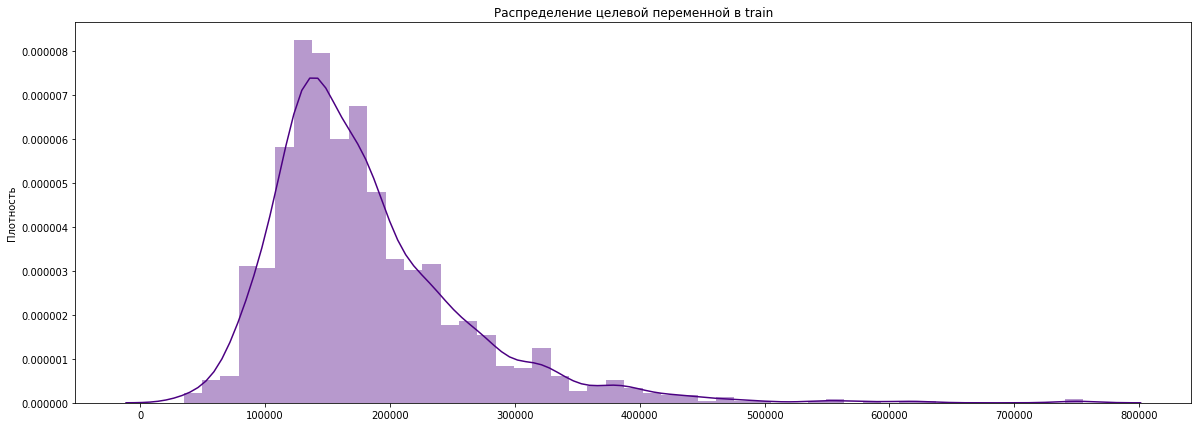

In [10]:
# посмотрим на распределение целевой переменной train_target
plt.figure(figsize=(20,7))
sns.distplot(train_target, color='indigo')
plt.title("Распределение целевой переменной в train")
plt.ylabel("Плотность")

In [11]:
stat_train, p_train = sts.normaltest(train_target) # тест на нормальность
p_train < 0.05 #  гипотеза о нормальности не отвергается

array([ True])

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

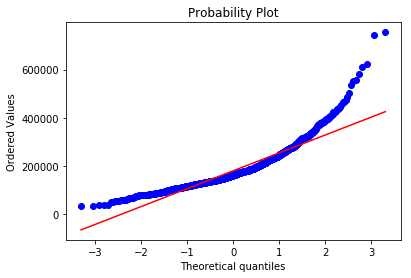

In [12]:
sts.probplot(train_target['SalePrice'], dist="norm", plot=plt)

Text(0, 0.5, 'Плотность')

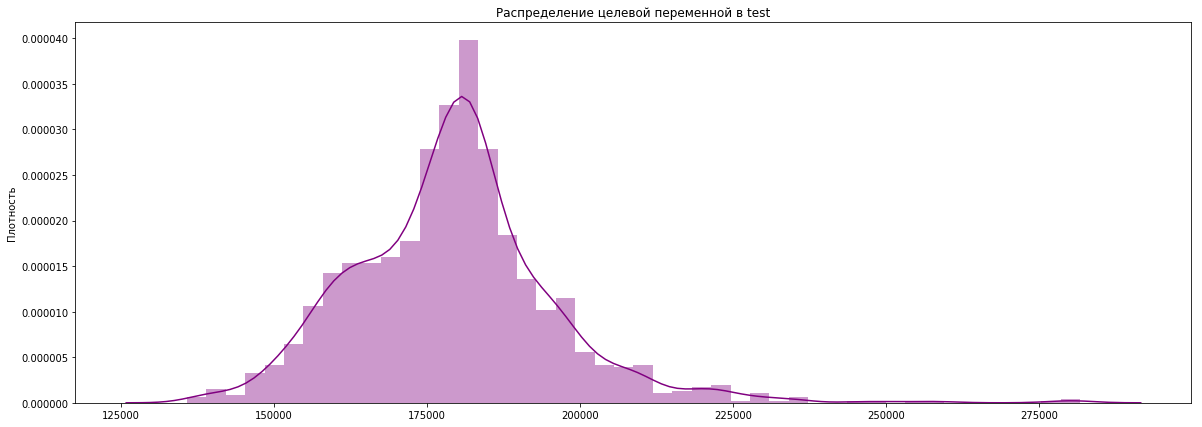

In [13]:
# посмотрим на распределение целевой переменной test_target
plt.figure(figsize=(20,7))
sns.distplot(test_target, color='purple')
plt.title("Распределение целевой переменной в test")
plt.ylabel("Плотность")

In [14]:
stat_test, p_test = sts.normaltest(test_target) # тест на нормальность
p_test < 0.05 #  гипотеза о нормальности не отвергается

array([ True])

((array([-3.30494753, -3.04772643, -2.90468264, ...,  2.90468264,
          3.04772643,  3.30494753]),
  array([135751.31889282, 137402.56985559, 138607.9714725 , ...,
         277936.12694354, 280618.13261726, 281643.97611679])),
 (16142.921840975023, 179183.91824266256, 0.9756608010462035))

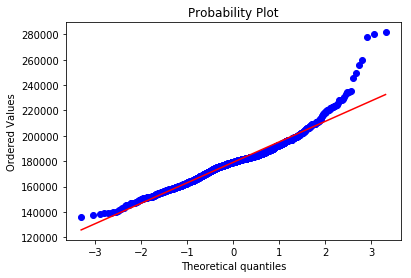

In [15]:
sts.probplot(test_target['SalePrice'], dist="norm", plot=plt)

#### Препроцессинг all_data для обучения регрессионной модели

In [16]:
all_data.sample(n=5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
732,50,RL,60.0,12180,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Family
1413,20,RL,88.0,10994,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,9,2009,COD,Abnorml
770,85,RL,NaN,7252,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal
989,60,FV,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2006,New,Partial
1302,60,RL,92.0,10120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,12,2006,WD,Normal


В данных:
- есть пропущенные значения;
- присутуствуют категориальные признаки
- числовые признаки имеют разный масштаб

#### Удаление пропущенных значений

In [17]:
# определим процент пропущенных значений в каждом столбце
def missing_values(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    col = missing_table.rename(columns = {0 : '#', 1 : '%'})
    return col

print("All data #"+str(len(all_data)))
cols = missing_values(all_data)
cols = cols.sort_values(by="%", ascending=False)
print(cols[cols['%'] >= 40])

All data #2919
                #          %
PoolQC       2909  99.657417
MiscFeature  2814  96.402878
Alley        2721  93.216855
Fence        2348  80.438506
FireplaceQu  1420  48.646797


Text(0.5, 1.0, 'Percent missing data by feature')

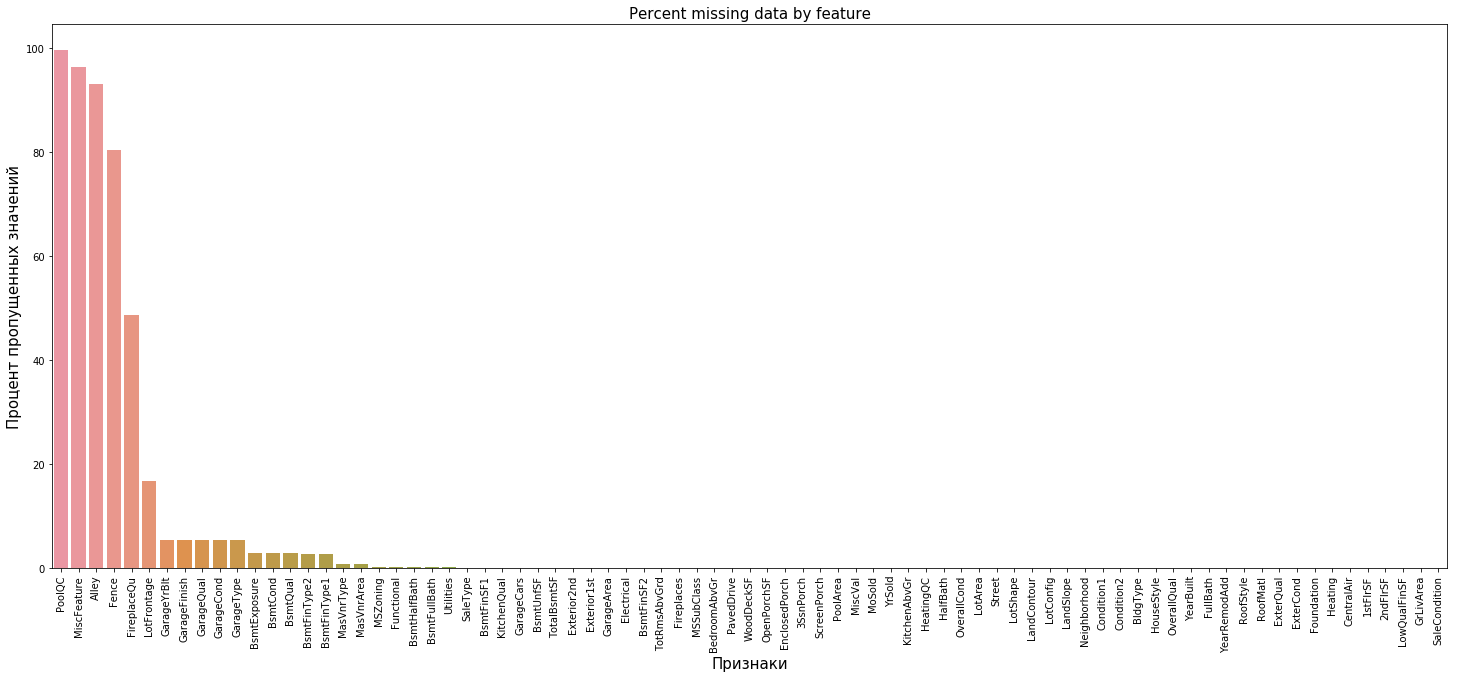

In [18]:
# визуализируем соотношение пропущенных значений в каждом столбце в %
f, ax = plt.subplots(figsize=(25, 10))
plt.xticks(rotation='90')
sns.barplot(x=cols.index, y=cols['%'])
plt.xlabel('Признаки', fontsize=15)
plt.ylabel('Процент пропущенных значений', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [19]:
# удаляем столбцы, где пропусков > 40%
all_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace = True)

####  Заполнение пропусков и масштабирование числовых признаков

In [20]:
# названия столбцов с числовыми признаками
cont_columns = all_data.columns[all_data.dtypes != 'object']

In [21]:
# заполним пропуски в данных средними значениями
# масштабирум признаки
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for column in cont_columns:
    all_data[column] = all_data[column].fillna(all_data[column].mean())
    all_data[column] = scaler.fit_transform(all_data[[column]])

#### Заполнение пропусков и преобразование категориальных признаков

In [22]:
# названия столбцов с категориальными признаками
categorical_columns = all_data.columns[all_data.dtypes == 'object']

In [23]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for column in categorical_columns:
    all_data[column] = all_data[column].fillna(all_data[column].mode()[0])
    all_data[column] = label_encoder.fit_transform(all_data[column])[0]
#     all_data[column] = pd.factorize(all_data[column])[0] Альтернативный способ преобразования категориальных признаков

#### Масштабирование целевой переменной

In [24]:
# масштабирум целевую переменную, чтобы масштаб не отличался
train_target = scaler.fit_transform(train_target)
test_target = scaler.fit_transform(test_target)

In [25]:
# посмотрим на полученные данные
all_data.sample(n=5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1187,-0.873616,3,0.924233,0.290767,1,3,3,0,4,0,...,0.984448,2.629506,-0.103331,-0.285935,-0.06315,-0.089592,0.289914,-1.363569,8,4
89,-0.167905,3,-0.812147,-0.498135,1,3,3,0,4,0,...,-0.554835,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-1.183764,1.678860,8,4
123,0.067331,3,0.267224,-0.100577,1,3,3,0,4,0,...,-0.140412,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-0.815344,1.678860,8,4
608,0.302568,3,0.408012,0.253611,1,3,3,0,4,0,...,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,1.026753,-0.602962,8,4
977,1.478753,3,-1.609944,-0.747449,1,3,3,0,4,0,...,1.014050,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,1.763592,-0.602962,8,4


#### Посмотрим на зависимость различных признаков

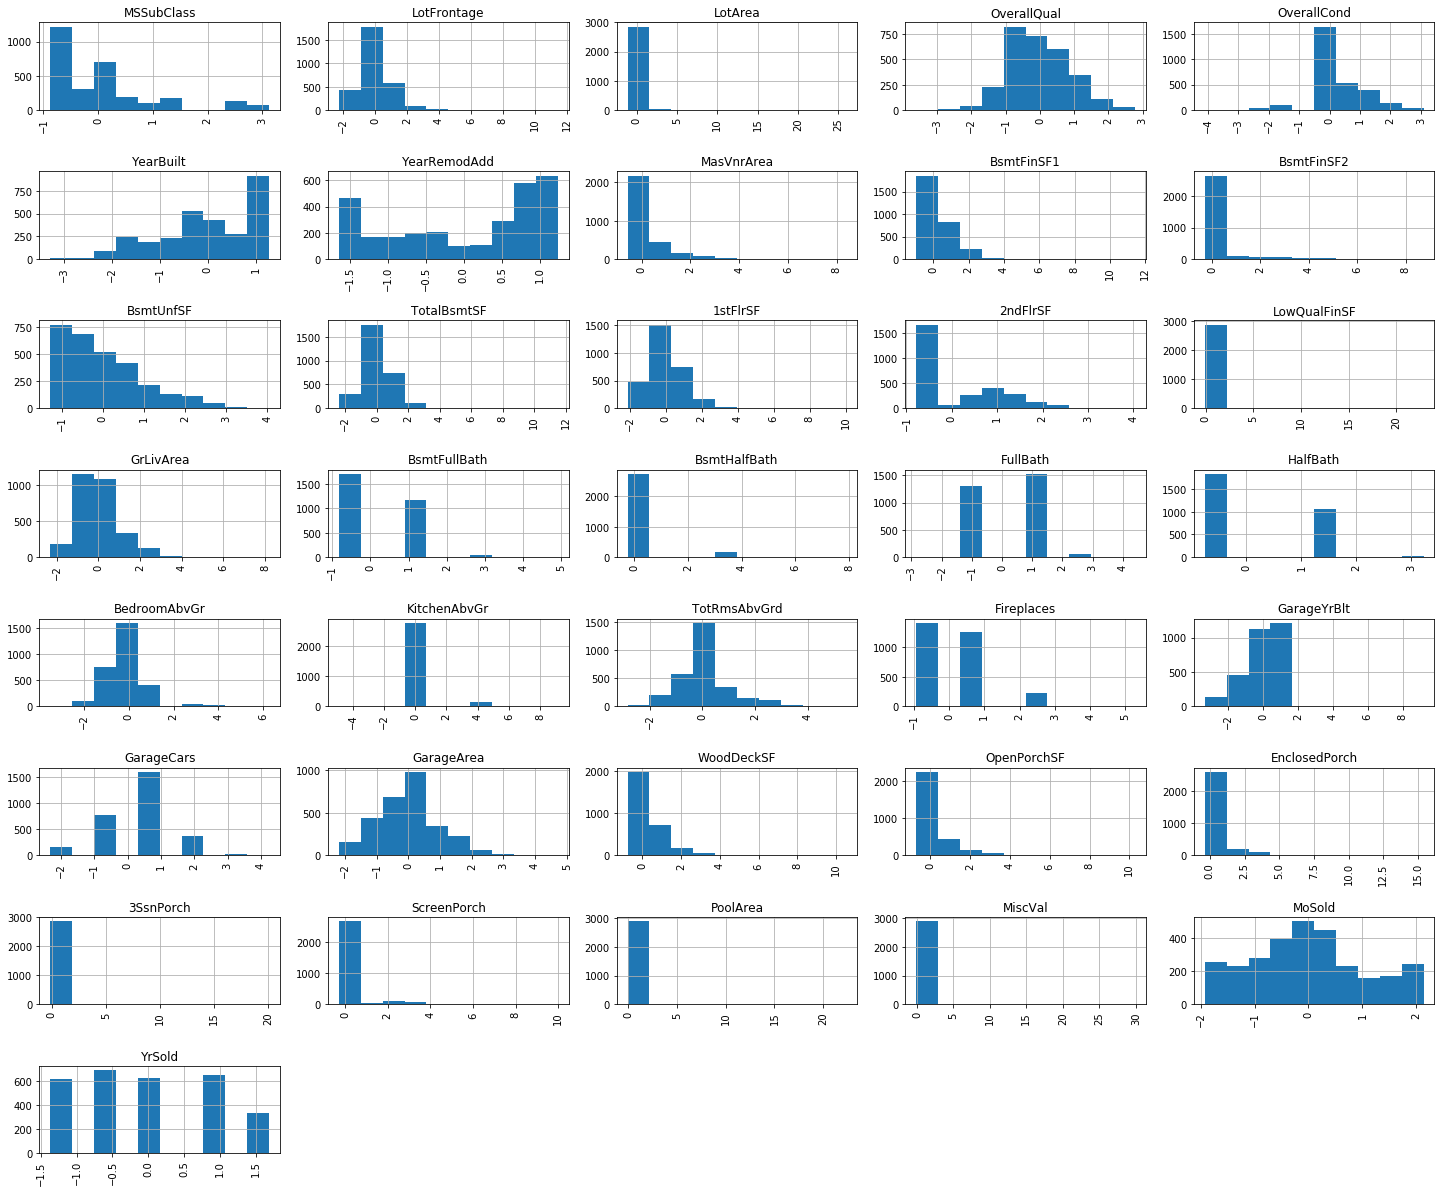

In [26]:
fig = plt.figure(figsize=(25,40))
cols = 5
rows = np.ceil(float(all_data.shape[1]) / cols)
for i, column in enumerate(all_data[cont_columns]):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    all_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#### Матрица корреляций признаков между собой

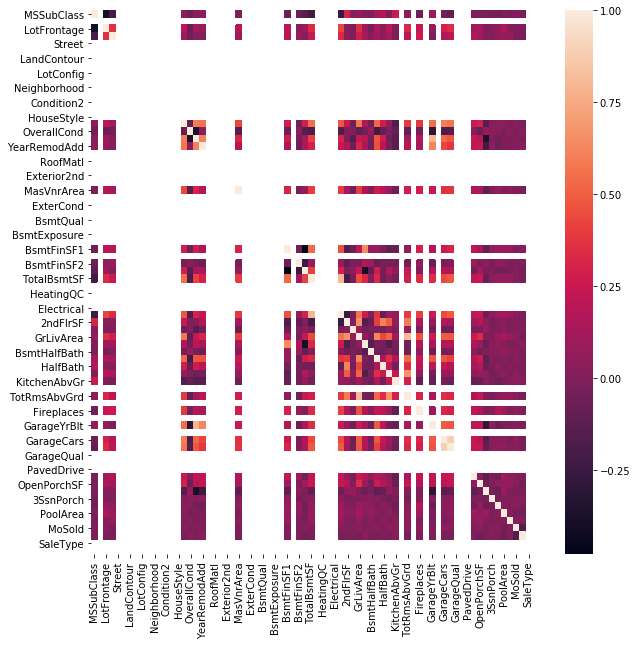

In [27]:
plt.subplots(figsize=(10,10))
sns.heatmap(all_data.corr())
plt.show()

In [28]:
ind = pd.DataFrame(np.where(all_data.corr() > 0.75)) # индексы столбцов и строк, где коэф. корреляции > 0.75
pd.set_option('display.max_columns', None)
ind

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0,2,3,15,16,17,17,18,24,32,34,35,36,36,41,41,42,43,44,44,45,46,47,48,49,50,52,52,54,56,56,58,58,59,59,63,64,65,66,67,68,69,70,71
1,0,2,3,15,16,17,56,18,24,32,34,35,36,41,36,41,42,43,44,52,45,46,47,48,49,50,44,52,54,17,56,58,59,58,59,63,64,65,66,67,68,69,70,71


In [29]:
# названия признаков (попарно), коэф. корреляции между которыми > 0.75
corr_cols = \
    [all_data.columns[36], all_data.columns[41],  
      all_data.columns[44], all_data.columns[52],   
      all_data.columns[56], all_data.columns[17]]

##### Матрица корреляций признаков с целевой переменной

In [30]:
# будем считать корреляцию всех признаков с целевой переменной test_target
SalePrice = pd.DataFrame(test_target, columns=['SalePrice']) # преобразуем test_target к типу DataFrame
total_data = all_data.append(SalePrice)

corrmat = total_data.corr()

/home/ymr1/venv/3.7/yan/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [31]:
k = 10
strong_cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(total_data[strong_cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=strong_cols.values, xticklabels=strong_cols.values)
plt.show()

ValueError: Must pass 2-d input

In [32]:
strong_cols = list(strong_cols) # признаки с большими коэф. корреляции с целевой переменной
strong_cols

['SalePrice']

#### Выбираем важные признаки для обучения

In [33]:
data = all_data[:1459] # данные для подбора признаков, размерности test_target

In [34]:
from sklearn.feature_selection import SelectKBest, f_classif

all_features = cont_columns.append(categorical_columns)

selector = SelectKBest(f_classif, len(all_features))
selector.fit(data[all_features], test_target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]

print('Важность признаков:')
for i in range(len(scores)):
    print('%.2f %s' % (scores[indices[i]], all_features[indices[i]]))

Важность признаков:
nan SaleCondition
nan Condition1
nan Exterior2nd
nan Exterior1st
nan RoofMatl
nan RoofStyle
nan HouseStyle
nan BldgType
nan Condition2
nan Neighborhood
nan ExterQual
nan LandSlope
nan LotConfig
nan Utilities
nan LandContour
nan LotShape
nan Street
nan SaleType
nan MasVnrType
nan MSZoning
nan ExterCond
nan Electrical
nan Foundation
nan PavedDrive
nan GarageCond
nan GarageFinish
nan GarageType
nan Functional
nan KitchenQual
nan GarageQual
nan CentralAir
nan HeatingQC
nan Heating
nan BsmtFinType2
nan BsmtFinType1
nan BsmtExposure
nan BsmtCond
nan BsmtQual
inf LowQualFinSF
inf PoolArea
inf MiscVal
5.52 EnclosedPorch
1.64 OpenPorchSF
1.61 KitchenAbvGr
1.38 ScreenPorch
0.91 GarageYrBlt
0.85 OverallCond
0.76 YearBuilt
0.60 3SsnPorch
0.56 LotArea
0.54 GarageArea
0.51 BsmtFullBath
0.50 LotFrontage
0.50 BedroomAbvGr
0.50 BsmtHalfBath
0.48 BsmtUnfSF
0.42 HalfBath
0.39 MoSold
0.34 Fireplaces
0.31 TotRmsAbvGrd
0.29 YearRemodAdd
0.28 TotalBsmtSF
0.21 BsmtFinSF1
0.19 WoodDeckSF
0.

/home/ymr1/venv/3.7/yan/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ymr1/venv/3.7/yan/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [14 32 33 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56
 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73] are constant.
  UserWarning)
/home/ymr1/venv/3.7/yan/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/ymr1/venv/3.7/yan/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/ymr1/venv/3.7/yan/lib/python3.7/site-packages/ipykernel_launcher.py:7: Runt

In [35]:
# выбранные важные признаки
fparams = \
    ['GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
     # признаки, сильно коррелирующие с целевой переменной
     'SaleCondition', 'Condition1', 'Exterior2nd', 'Exterior1st', 'RoofMatl','RoofStyle','HouseStyle', #'TotRmsAbvGrd'
     'BldgType','Neighborhood','ExterQual','LandSlope','LotConfig','Utilities','LandContour','Condition2',
     'LotShape','Street','SaleType','MasVnrType','MSZoning','ExterCond','Electrical','Foundation','PavedDrive',
     'GarageCond','GarageFinish','GarageType','Functional','KitchenQual','GarageQual','CentralAir','HeatingQC',
     'Heating','BsmtFinType2','BsmtFinType1','BsmtExposure','BsmtCond','BsmtQual','LowQualFinSF','PoolArea','MiscVal']
     #  удалён один из коррелирующих между собой признаков ''TotRmsAbvGrd' (с 'GrLivArea), 'LandContour' (с 'ExterQual)'
     # '1stFlrSF', коррелирующего с 'TotalBsmtSF' и 'GarageYrBlt', коррелирующий с 'YearBuilt' не оказались в списке

#### Подготовим данные для обучения

In [36]:
all_data = all_data[fparams] # данные с выбранными признаками (48 из 79)

In [37]:
all_data.shape # размерность данных не соответствует размерности test__target

(2919, 48)

In [38]:
# разделим данные, чтобы получить размерность test_target
train = all_data[:1460]
test  = all_data[1460:]

In [39]:
train.shape

(1460, 48)

In [40]:
# преобразуем train_target, test_target к типу DataFrame
train_target = pd.DataFrame(train_target, columns=['SalePrice'])
test_target = pd.DataFrame(test_target, columns=['SalePrice']) 

In [41]:
train_features = train[fparams].values
test_features  = test[fparams].values
train_target = train_target.values
test_target = test_target.values

In [42]:
import warnings
warnings.filterwarnings('ignore')

#### Обучение Lasso с подбором параметров

In [43]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

lasso_regressor = Lasso()

params = [{'alpha' : [0.00001, 10, 0.001]}]

gs = GridSearchCV(lasso_regressor, param_grid = params, scoring = 'neg_mean_squared_error', cv = 5)
gs.fit(train_features, train_target)
print('Наилучший набор параметров модели Lasso', gs.best_estimator_)

Наилучший набор параметров модели Lasso Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [44]:
lasso_regressor = Lasso(alpha=0.001)
lasso_regressor.fit(train_features, train_target)
lasso_predictions = lasso_regressor.predict(test_features)

print('RMSE= {}'.format(np.sqrt(mean_squared_error(test_target, lasso_predictions))))

RMSE= 1.0003895589998446


Text(0, 0.5, 'Плотность')

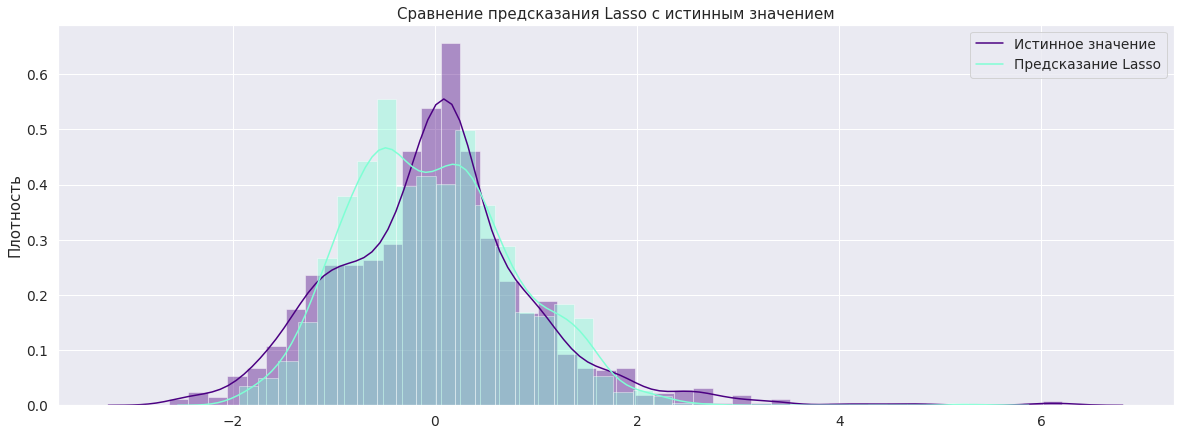

In [45]:
plt.figure(figsize=(20,7))
sns.distplot(test_target, color='indigo', kde_kws={"label" : "Истинное значение"})
sns.distplot(lasso_predictions, color='aquamarine', kde_kws={"label" : "Предсказание Lasso"})
plt.title("Сравнение предсказания Lasso с истинным значением")
plt.ylabel("Плотность")

####  Обучим Catboost

In [46]:
import catboost

In [47]:
# индексы столбцов с категориальными признаками
categ_feat_idx = np.where(cb_data.dtypes == 'object')[0]
categ_feat_idx

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23,
       24, 26, 27, 28, 29, 30, 31, 32, 34, 38, 39, 40, 41, 52, 54, 56, 57,
       59, 62, 63, 64, 71, 72, 73, 77, 78])

In [48]:
# названия столбцов с категориальными признаками
categ_feat = cb_data.columns[categ_feat_idx]

In [49]:
# заменим значения NaN в cb_data, test
# cat_features must be integer or string, real number values and NaN values should be converted to string

for column in categ_feat:
    cb_data[column] = cb_data[column].fillna(cb_data[column].mode()[0])
   # cb_data[column] = str(cb_data[column])

for column in categ_feat:
    cb_test[column] = cb_test[column].fillna(cb_test[column].mode()[0])

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(cb_data, cb_target, train_size=0.75, random_state=42)

In [51]:
from catboost import CatBoostRegressor, Pool, cv

cat_features = categ_feat_idx

model = CatBoostRegressor(
    learning_rate=0.5,
    iterations=50,
#    custom_metric=['RMSE'],
    random_seed=42, 
    loss_function='RMSE',
    od_wait=5 #если не улучшил качество на последние 5 итераций, остановись
)

In [52]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [53]:
cb_predictions = model.predict(cb_test)
print('RMSE= {}'.format(np.sqrt(mean_squared_error(test_target, cb_predictions))))

RMSE= 181848.65389440375


Text(0, 0.5, 'Плотность')

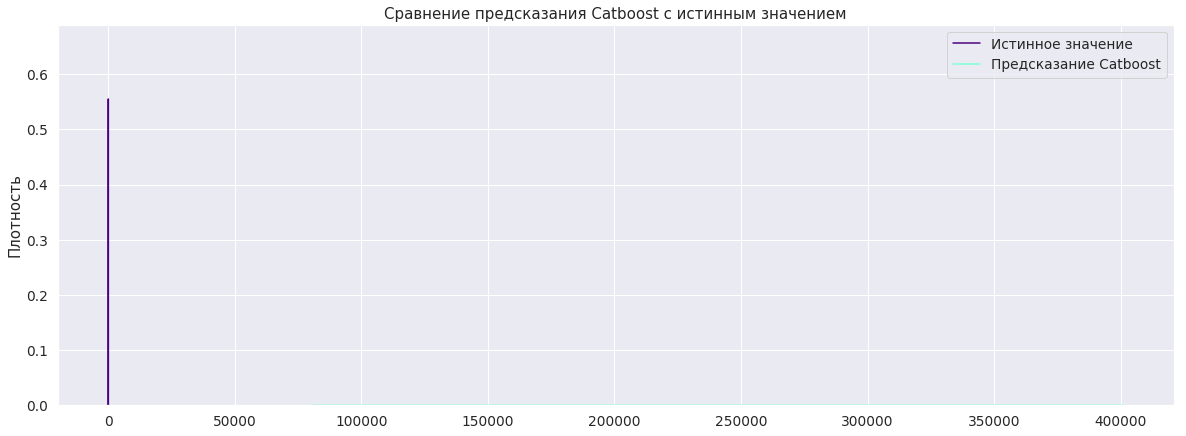

In [54]:
plt.figure(figsize=(20,7))
sns.distplot(test_target, color='indigo', kde_kws={"label" : "Истинное значение"})
sns.distplot(cb_predictions, color='aquamarine', kde_kws={"label" : "Предсказание Catboost"})
plt.title("Сравнение предсказания Catboost с истинным значением")
plt.ylabel("Плотность")

#### Попробуем улучшить качество с помошью подбора параметров  по кросс-валидации

In [55]:
params = model.get_params()
params['iterations'] = 100
params['learning_rate'] = 0.03 
params['random_seed'] = 63
params['custom_loss'] = 'RMSE'

cv_data = cv(
    params = params,
    pool = Pool(X_train, y_train, cat_features=cat_features),
    fold_count=3,
 #   type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    stratified=True,  
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 191492.0764540	test: 187482.7448192	best: 187482.7448192 (0)
1:	learn: 186813.9483725	test: 182779.9434224	best: 182779.9434224 (1)
2:	learn: 182239.4776389	test: 178196.5209017	best: 178196.5209017 (2)
3:	learn: 177810.7580173	test: 173751.9141700	best: 173751.9141700 (3)
4:	learn: 173510.8998605	test: 169452.7083030	best: 169452.7083030 (4)
5:	learn: 169378.9518665	test: 165317.9555808	best: 165317.9555808 (5)
6:	learn: 165377.2011371	test: 161275.2436856	best: 161275.2436856 (6)
7:	learn: 161524.9330891	test: 157404.1896868	best: 157404.1896868 (7)
8:	learn: 157825.1380117	test: 153659.7231297	best: 153659.7231297 (8)
9:	learn: 154208.1712881	test: 150004.0939591	best: 150004.0939591 (9)
10:	learn: 150763.8212588	test: 146520.8189698	best: 146520.8189698 (10)
11:	learn: 147425.7839994	test: 143216.4154641	best: 143216.4154641 (11)
12:	learn: 144249.2253895	test: 140025.6995482	best: 140025.6995482 (12)
13:	learn: 141146.5614859	test: 136922.6183751	best: 136922.6183751 (13

In [56]:
best_value = np.min(cv_data)
print ('Лучший показатель по метрике RMSE: {}'.format(best_value)) 

Лучший показатель по метрике RMSE: iterations             0.000000
test-RMSE-mean     69664.200219
test-RMSE-std      16784.706888
train-RMSE-mean    69938.000332
train-RMSE-std      4548.353644
dtype: float64


#### Качество по сравнению с Lassoрегрессией улучшить не удалось